# Denoising MWTA v2

## Intro
* **Date**: 1/13/2021
* **What**: I'm basically running the denoising mwta experiment from the Sparse Coding project again, but this time I'm using fewer winners, constant initialization, and more neurons.
* **Why**: Because this is actually an incredibly important problem, and I think I can do much better than I did the first time around.  By using fewer winners and more neurons, I'm finding more robust and complete structures, so hopefully the de-noised reconstructions will be significantly better.
* **Hopes**: Some incredibly good de-noised reconstructions.
* **Limitations**: I mean, I'm basically trying to find structure within a bunch of noisy information.  That's kinda a super hard problem.  So yeah, things could not work properly.  That being said, I had a good deal of success with this the last time I tried it, so I'm pretty optimistic.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from numba import njit
from time import time

(train_x, train_y), (test_x, test_y) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val, vmin=0)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [2]:
m_noise = np.clip(m_flat_tr + np.random.normal(0, 0.2, m_flat_tr.shape), 0, 1)
gp_noise = cp.asarray(m_noise)

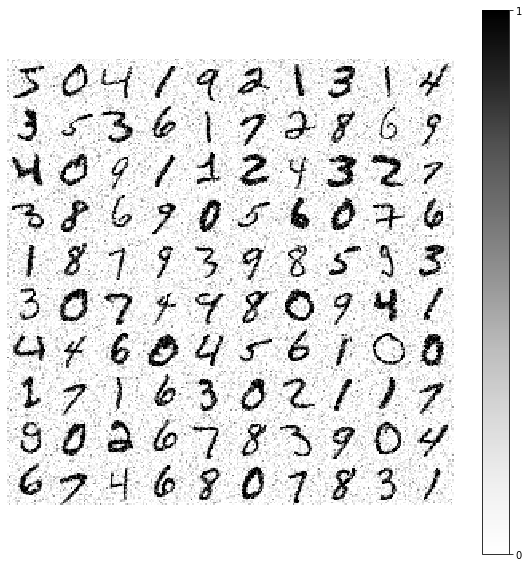

In [3]:
fig = plt.figure(figsize=(10, 10))

draw_weights(m_noise, 10, 10, 28, fig)

In [14]:
def reconstruct(img_i, w, Kx, Ky, gp, vmax, vmin, n_w):
    s_len = 28

    img = gp[img_i]

    v = img.reshape(-1, 1)
    p = w @ v
    winners = cp.argsort(p, axis=0)[-n_w:]
    mask = cp.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o.reshape(Ky, Kx).get(), cmap="Greys")

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(r.reshape(s_len, s_len).get(), cmap="Greys", vmax=vmax, vmin=vmin)

    plt.show()

## Analysis Dialog

Alright, we have the first, pretty easy noise signature.  Let's see what the ol' network can do.  

<IPython.core.display.Javascript object>


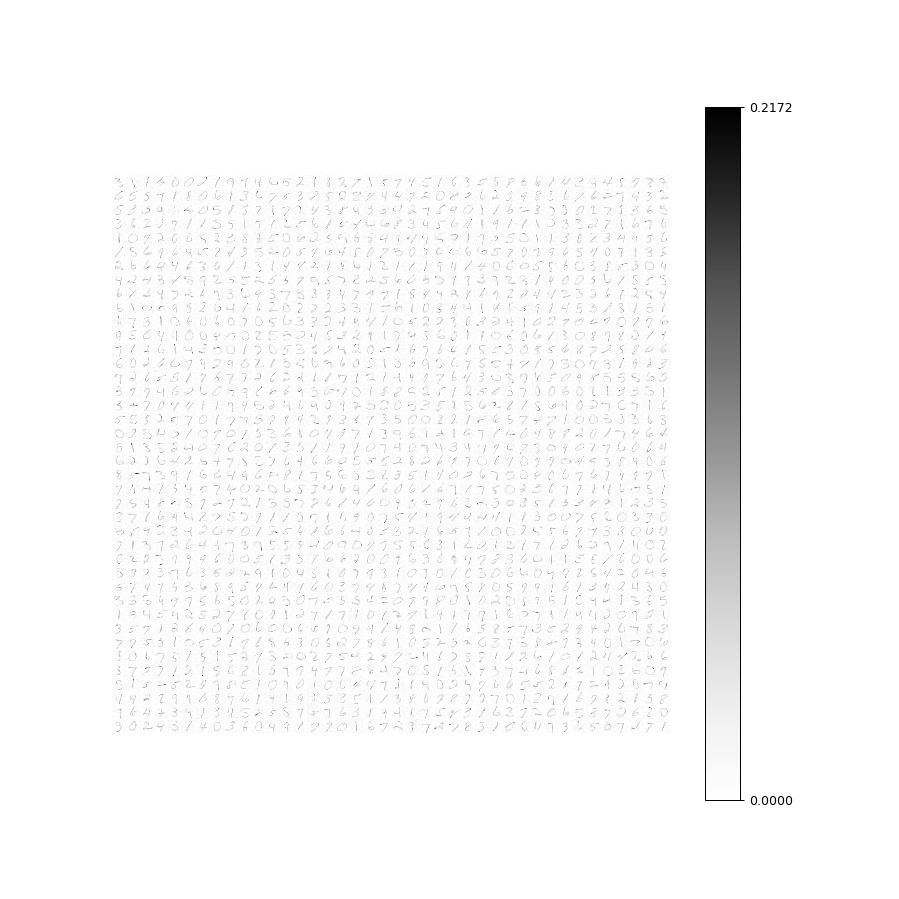

100%|██████████| 6000/6000 [00:03<00:00, 1806.37it/s]


In [19]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 40
Ky = 40
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(.1, .11, (N, m_len))
xi = 0.03

for ep in range(Nep):
    inputs = gp_noise[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


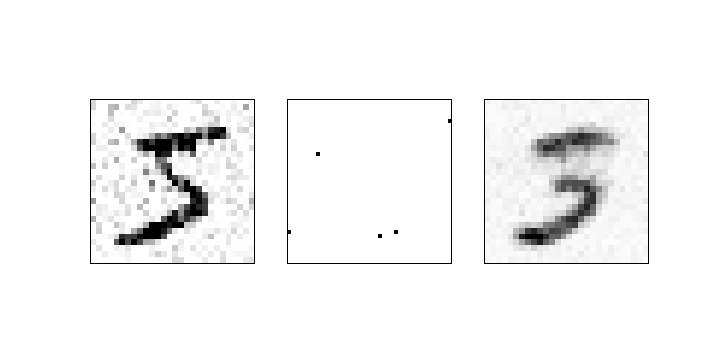

<IPython.core.display.Javascript object>


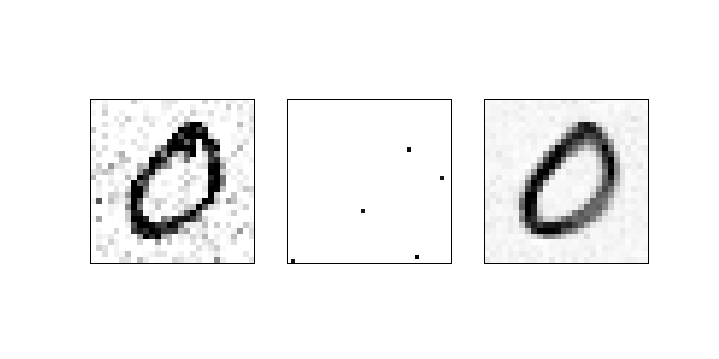

<IPython.core.display.Javascript object>


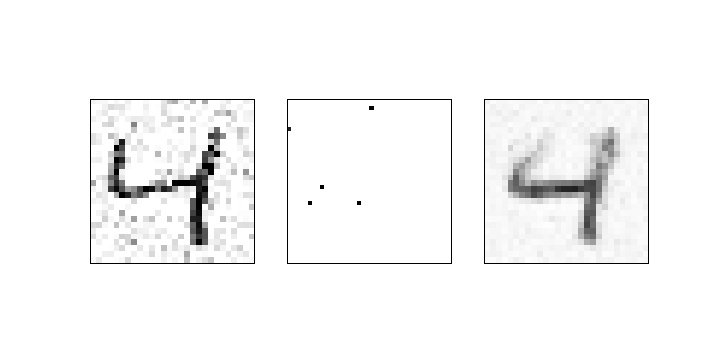

<IPython.core.display.Javascript object>


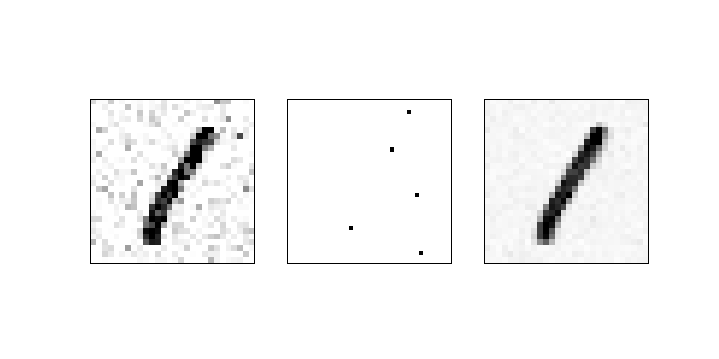

<IPython.core.display.Javascript object>


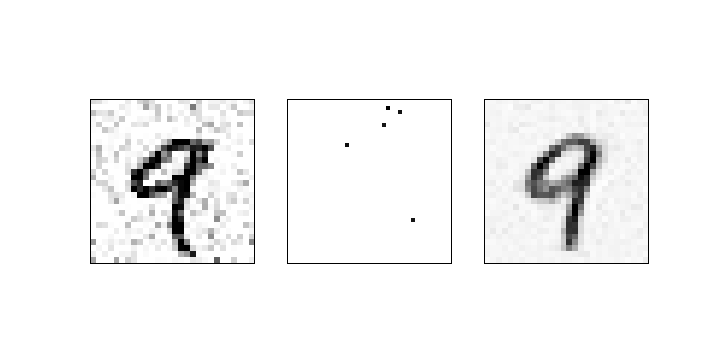

<IPython.core.display.Javascript object>


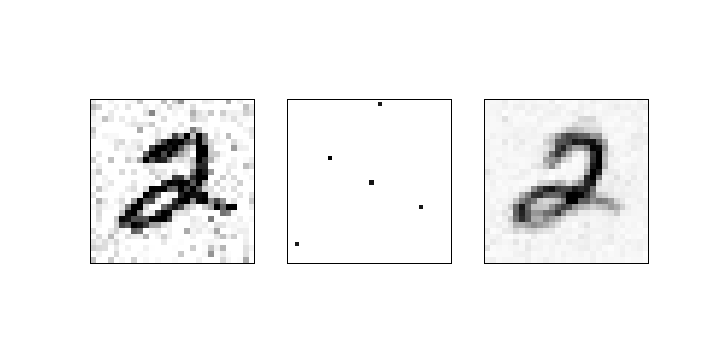

<IPython.core.display.Javascript object>


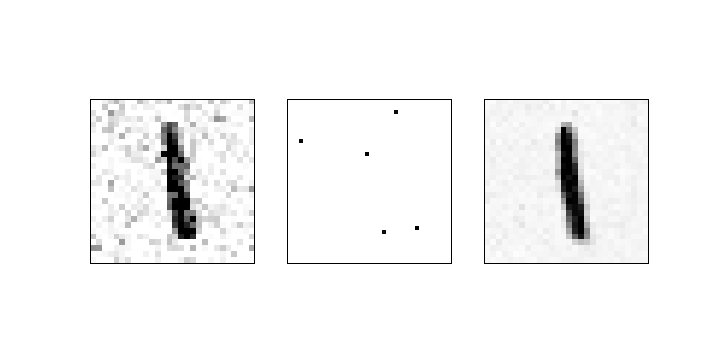

<IPython.core.display.Javascript object>


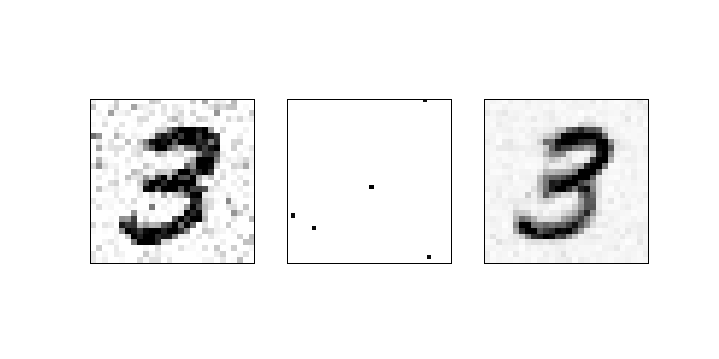

<IPython.core.display.Javascript object>


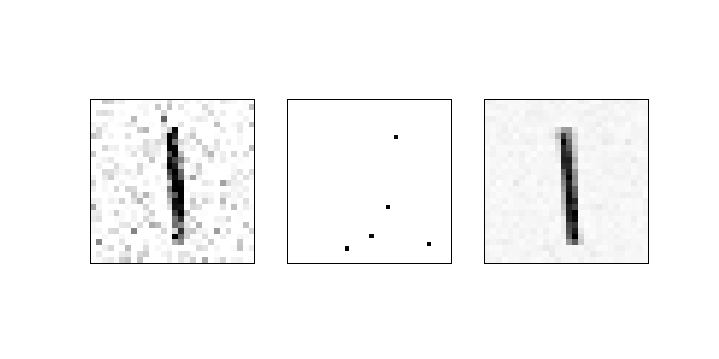

<IPython.core.display.Javascript object>


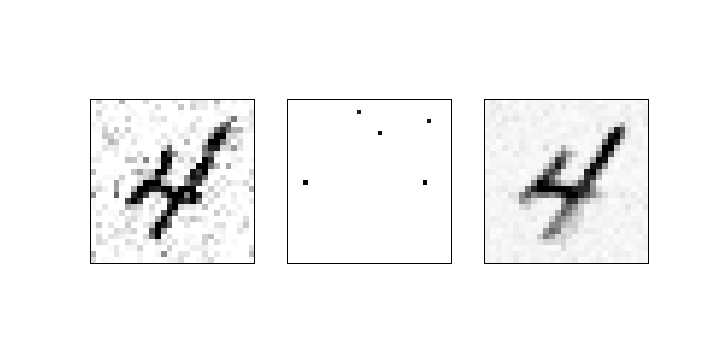

In [20]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise, 1, 0, n_w)

Hmm, ok, those reconstructions are pretty darn good.  But I'm more interested in what happens with the most aggressively corrupted noise profiles.  Let's bring those in, shall we?

In [21]:
m_noise0 = np.clip(m_flat_tr + np.random.normal(-1, 0.5, m_flat_tr.shape), 0, 1)
gp_noise0 = cp.asarray(m_noise0)

<IPython.core.display.Javascript object>


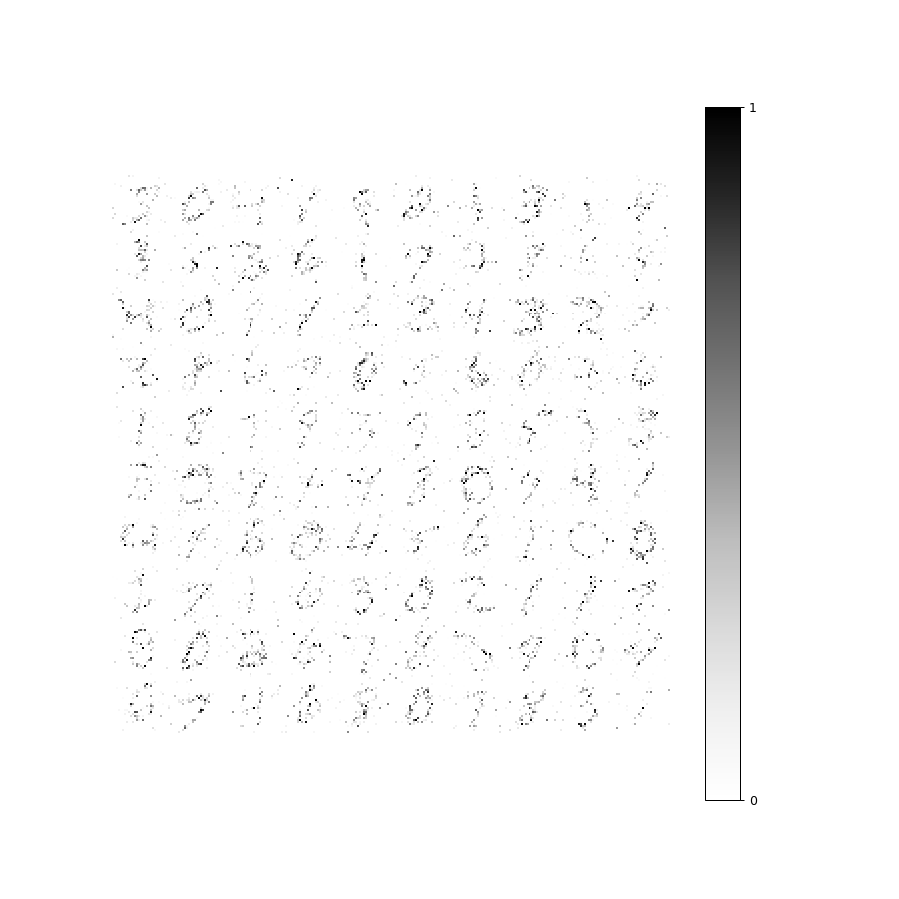

In [22]:
fig = plt.figure(figsize=(10, 10))

draw_weights(gp_noise0.get(), 10, 10, 28, fig)

Haha.  Yeah that's brutal.  Let's give that one a twirl.

<IPython.core.display.Javascript object>


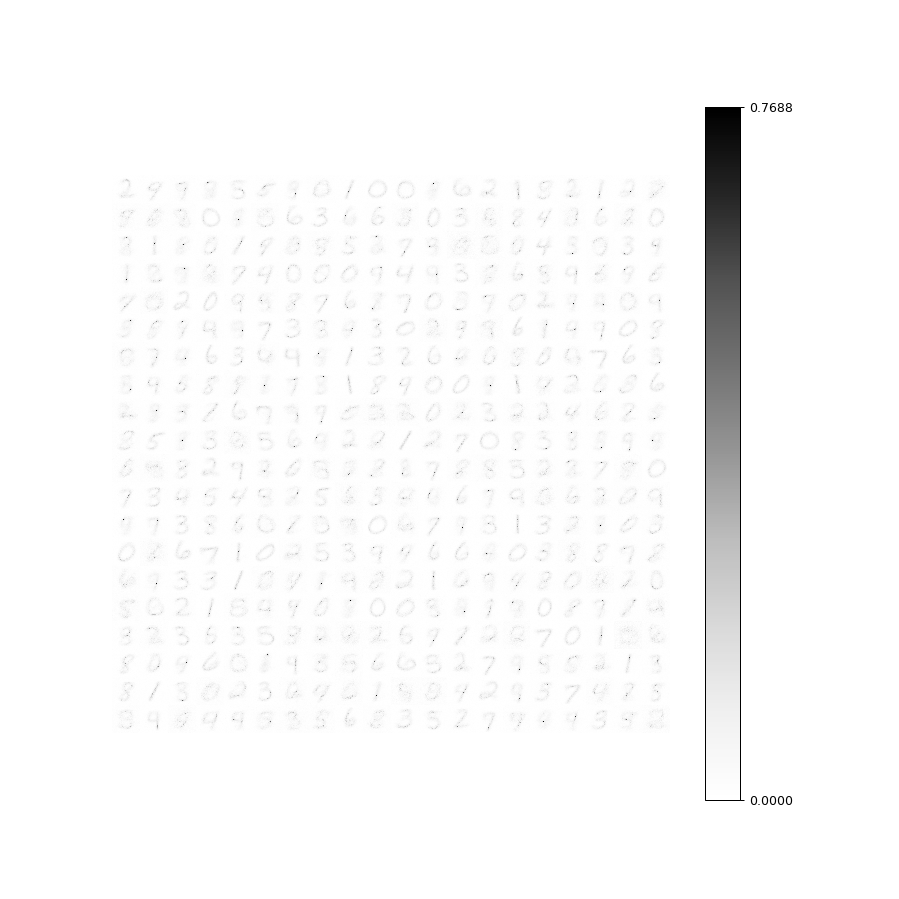

100%|██████████| 12000/12000 [00:05<00:00, 2056.47it/s]


In [31]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 12000

Kx = 20
Ky = 20
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 1 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, .2, (N, m_len))
xi = 0.01

for ep in range(Nep):
    inputs = gp_noise0[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


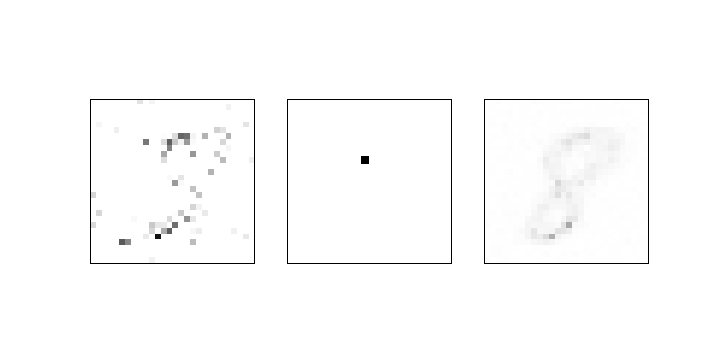

<IPython.core.display.Javascript object>


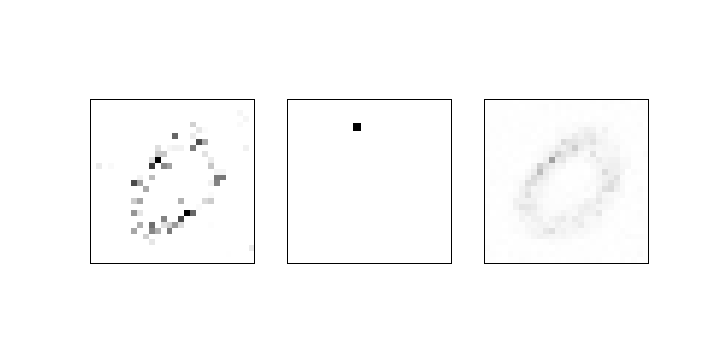

<IPython.core.display.Javascript object>


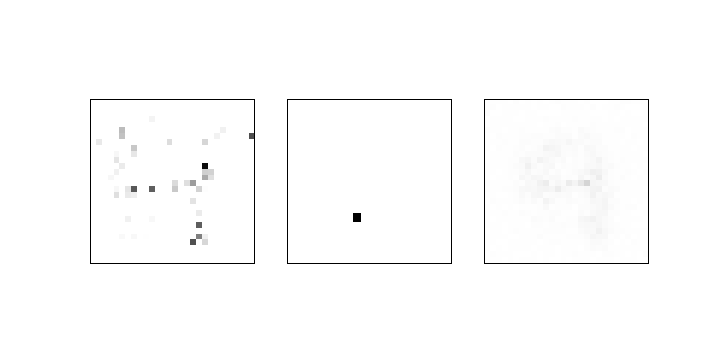

<IPython.core.display.Javascript object>


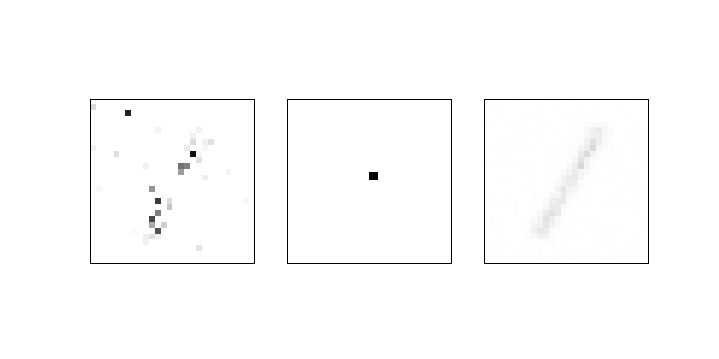

<IPython.core.display.Javascript object>


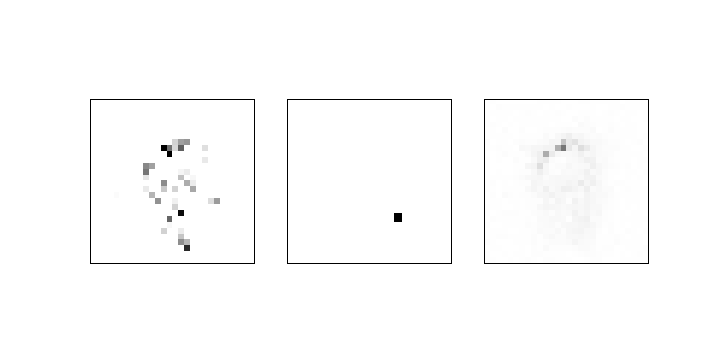

<IPython.core.display.Javascript object>


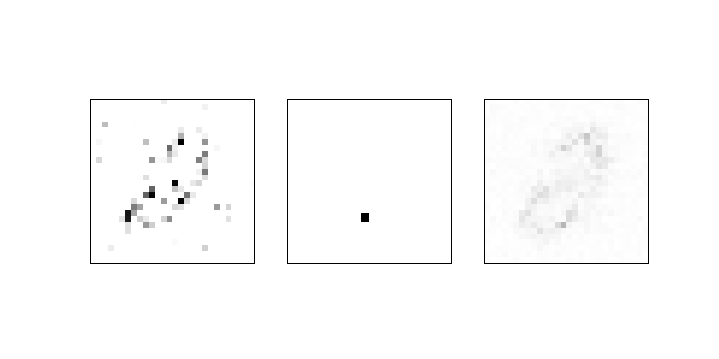

<IPython.core.display.Javascript object>


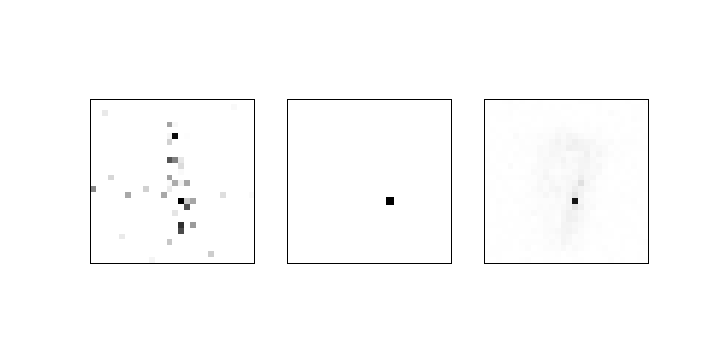

<IPython.core.display.Javascript object>


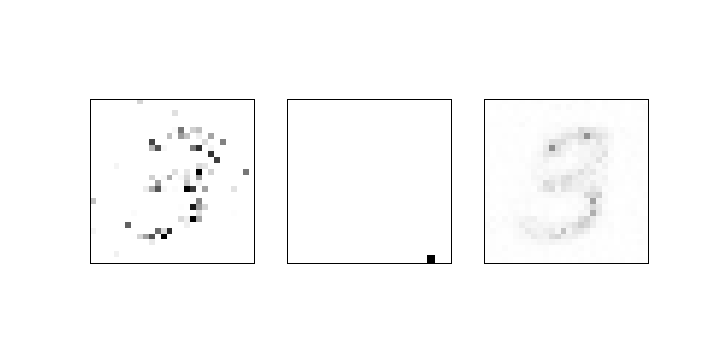

<IPython.core.display.Javascript object>


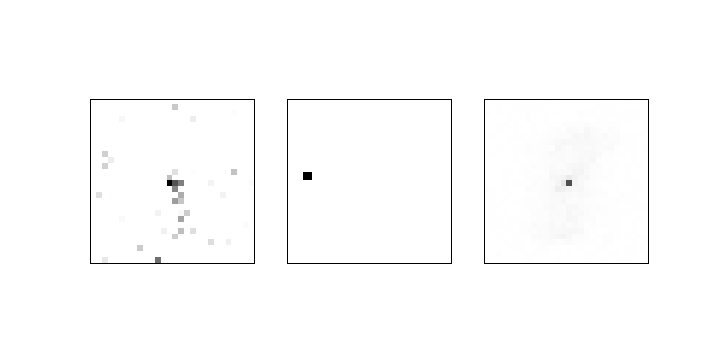

<IPython.core.display.Javascript object>


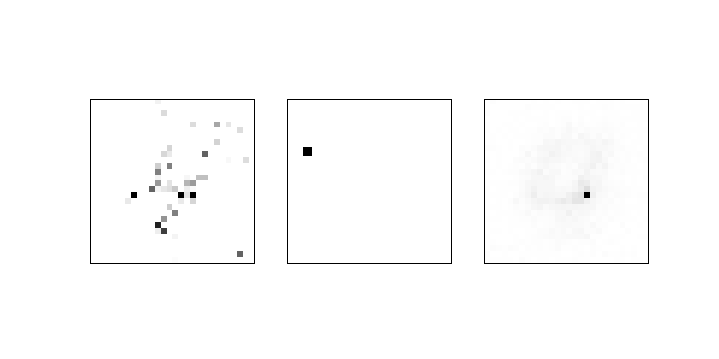

In [32]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise0, 1, 0, n_w)

Man alive.  Well, that dataset what a let down.  It'll be interested to see how that one does when I allow hypothesis imposition in a future experiment.  That might make it way better or way worse.  We'll see.  Anyway, let's try the super super noisy dataset.

In [33]:
m_noise5 = np.clip(m_flat_tr + np.random.normal(0, 0.5, m_flat_tr.shape), 0, 1)
gp_noise5 = cp.asarray(m_noise5)

<IPython.core.display.Javascript object>


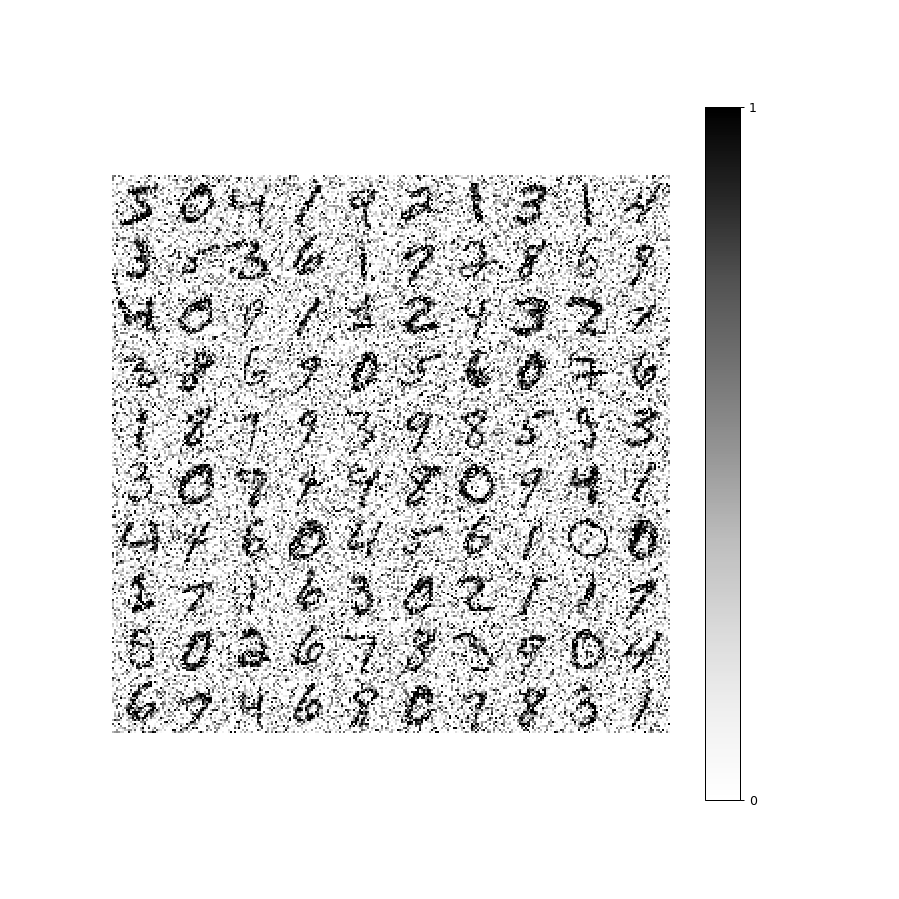

In [34]:
fig = plt.figure(figsize=(10, 10))

draw_weights(m_noise5, 10, 10, 28, fig)

<IPython.core.display.Javascript object>


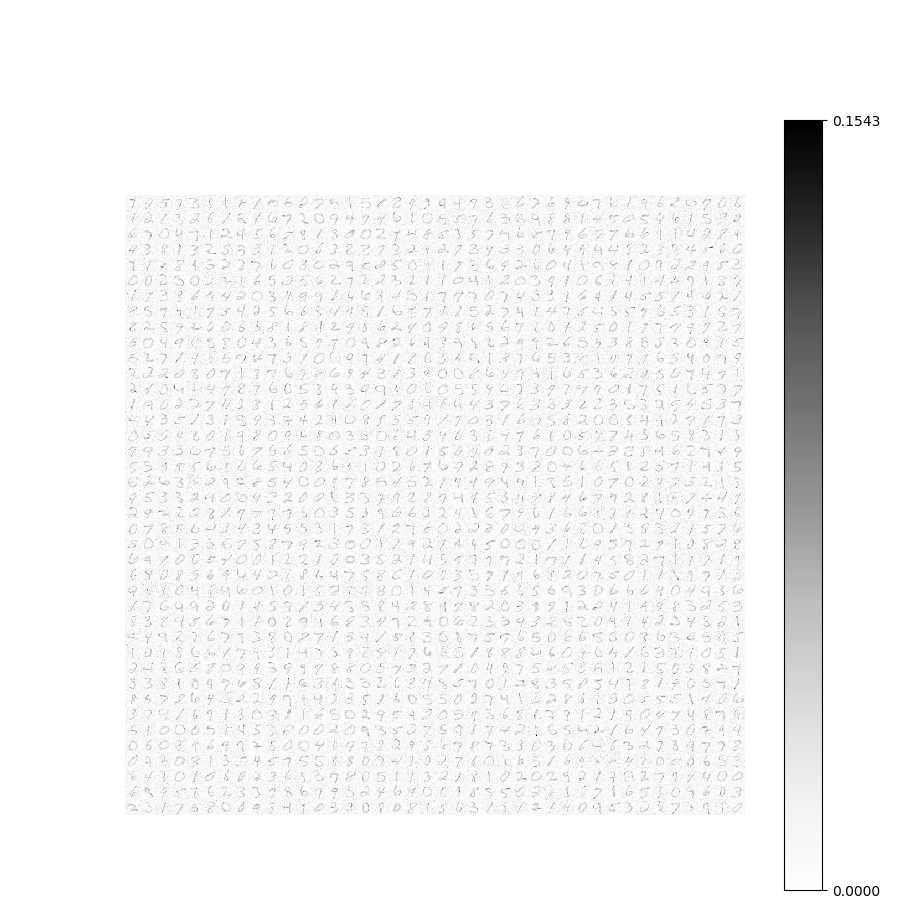

 54%|█████▍    | 6507/12000 [00:03<00:03, 1779.89it/s]


KeyboardInterrupt: 

In [36]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 12000

Kx = 40
Ky = 40
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(.1, .11, (N, m_len))
xi = 0.01

for ep in range(Nep):
    inputs = gp_noise5[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


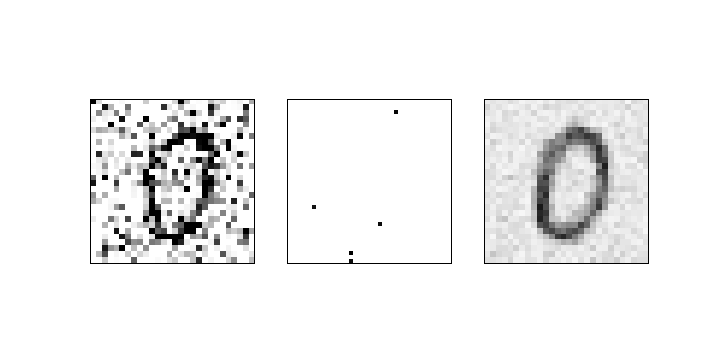

<IPython.core.display.Javascript object>


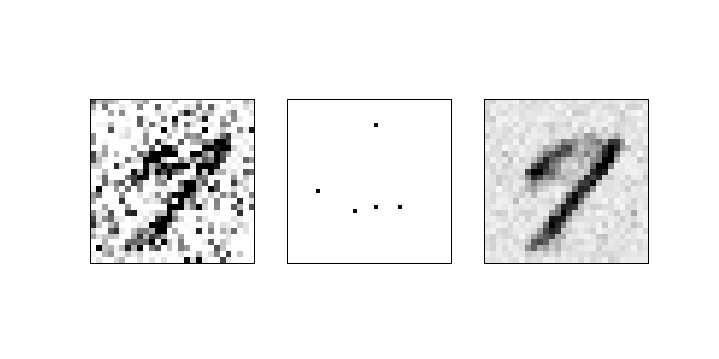

<IPython.core.display.Javascript object>


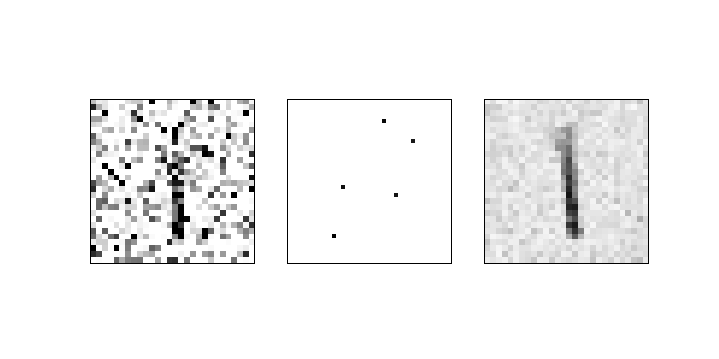

<IPython.core.display.Javascript object>


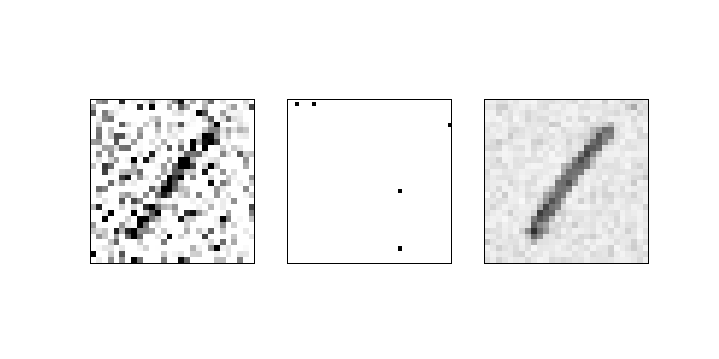

<IPython.core.display.Javascript object>


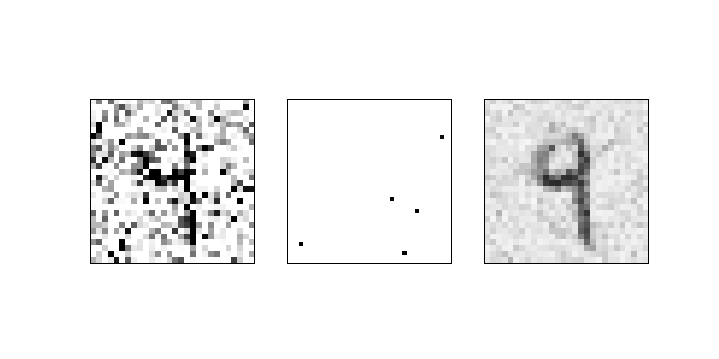

<IPython.core.display.Javascript object>


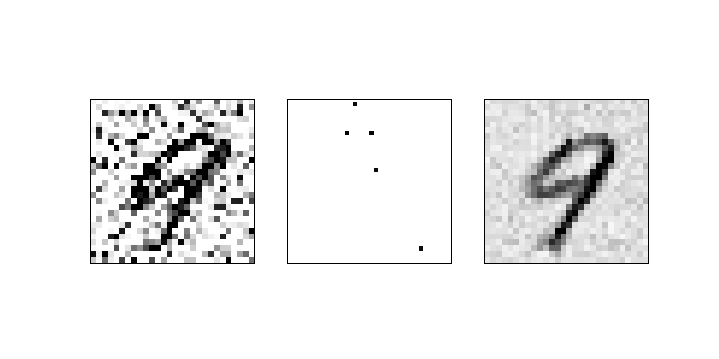

<IPython.core.display.Javascript object>


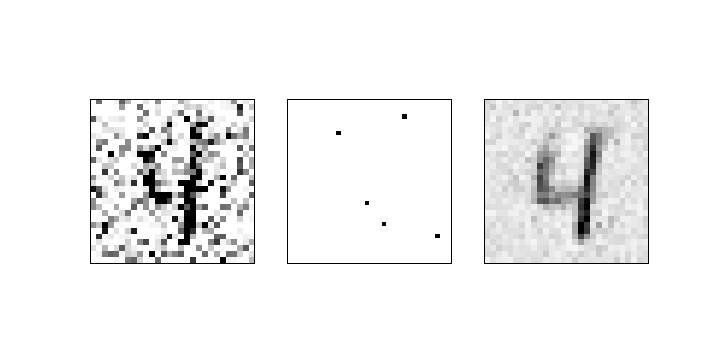

<IPython.core.display.Javascript object>


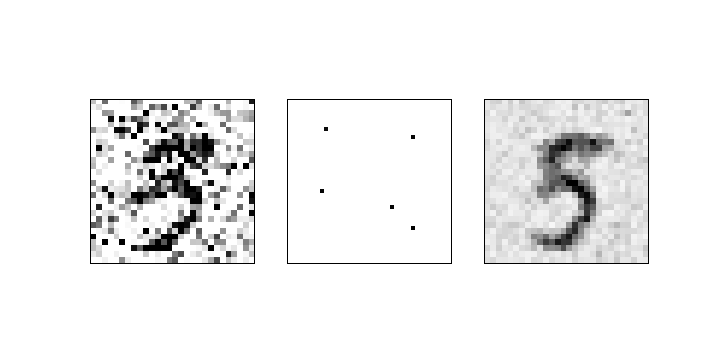

<IPython.core.display.Javascript object>


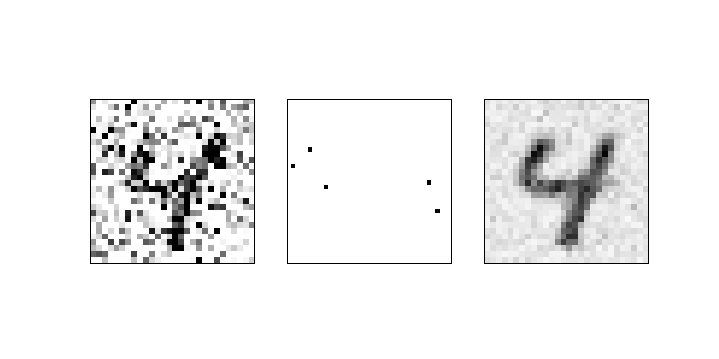

<IPython.core.display.Javascript object>


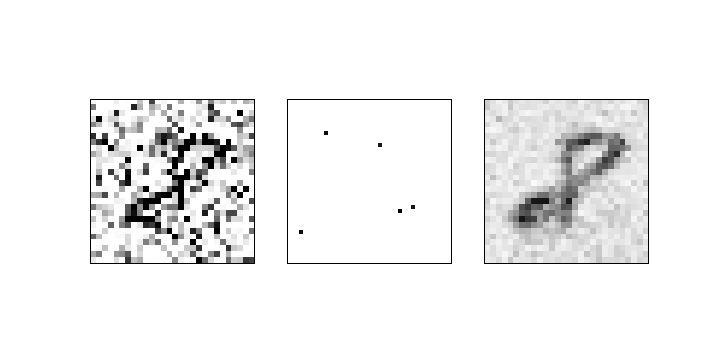

In [39]:
offset = 1000

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise5, 1, 0, n_w)

Well, that one is incredibly dope.  With some of those, it's picking up on structure that's difficult for even me, a card-carrying human being, to see. 

Ok, here's a profile that I think will be easier than gp_noise0.

There's definitely still some structure, but the image is pretty darn corrupted.

In [40]:
m_noise10 = np.clip(m_flat_tr + np.random.normal(-0.5, 0.5, m_flat_tr.shape), 0, 1)
gp_noise10 = cp.asarray(m_noise10)

<IPython.core.display.Javascript object>


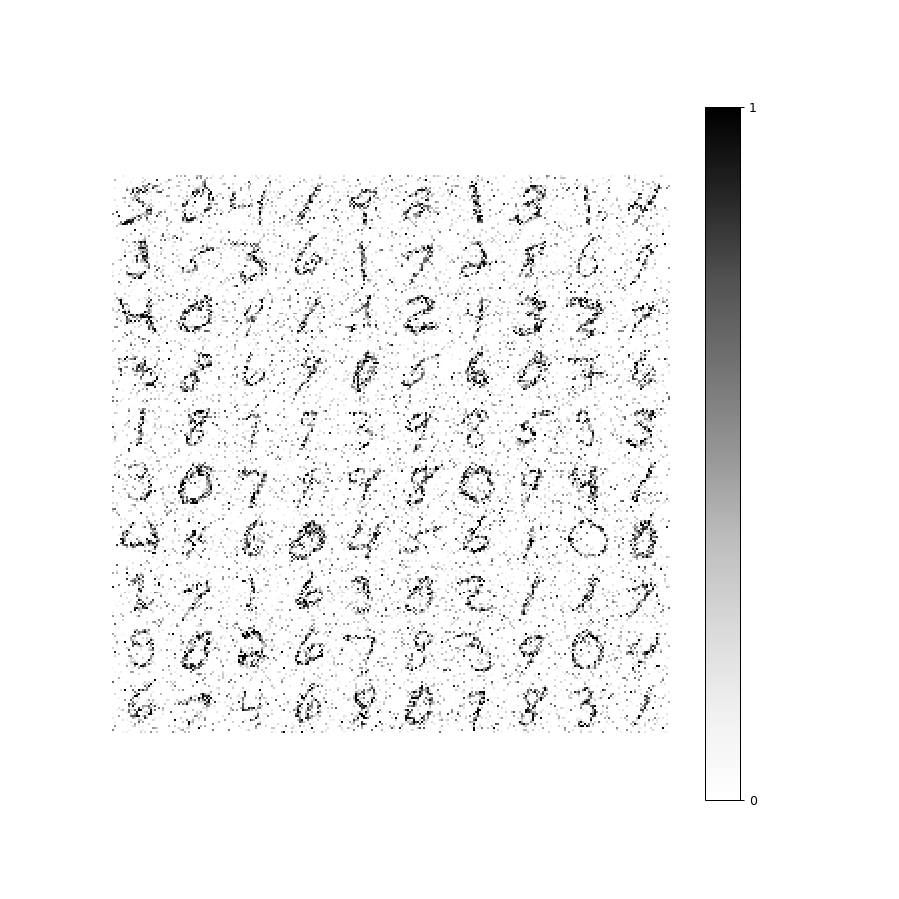

In [41]:
fig = plt.figure(figsize=(10, 10))

draw_weights(gp_noise10.get(), 10, 10, 28, fig)

<IPython.core.display.Javascript object>


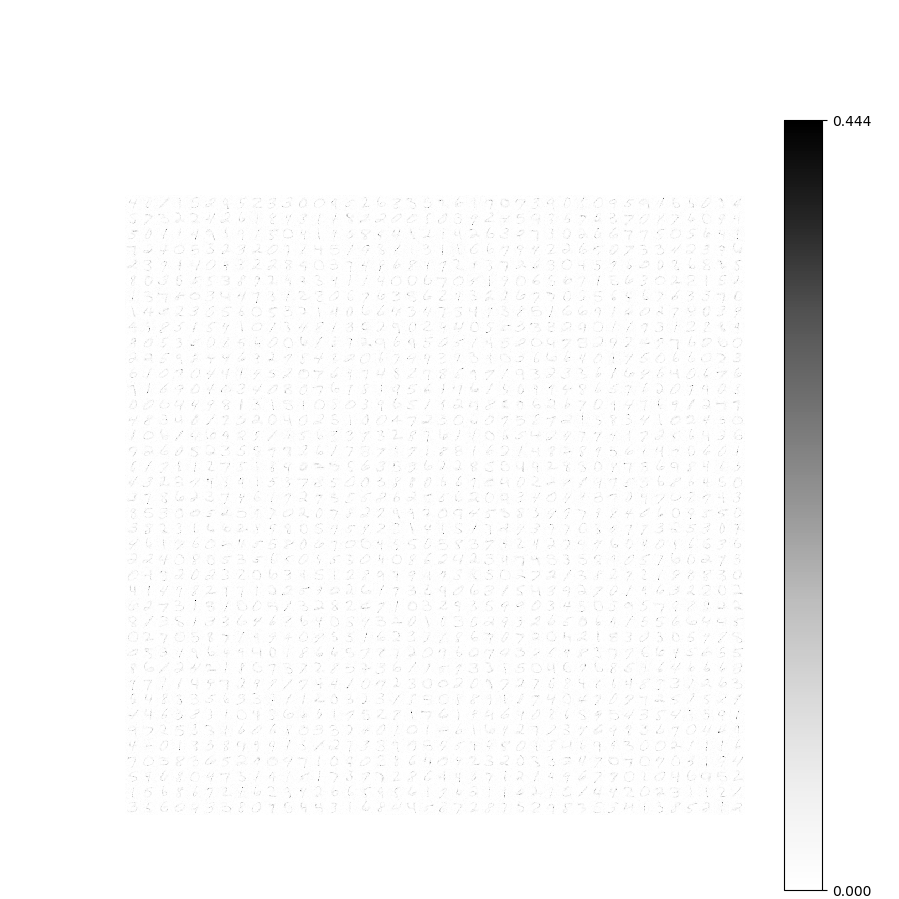

 95%|█████████▍| 11343/12000 [00:06<00:00, 1773.11it/s]


KeyboardInterrupt: 

In [42]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 12000

Kx = 40
Ky = 40
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 5 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(.1, .11, (N, m_len))
xi = 0.01

for ep in range(Nep):
    inputs = gp_noise10[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    draw_weights(w.get(), Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


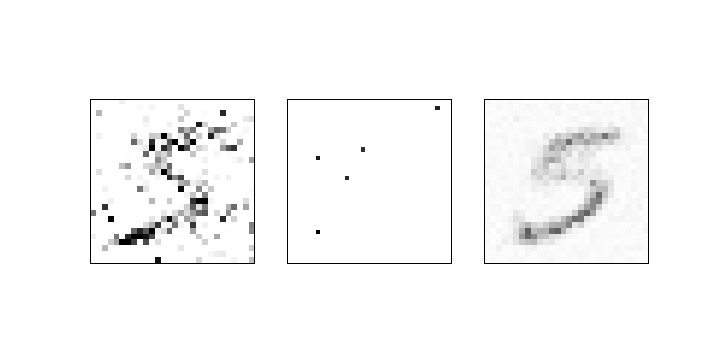

<IPython.core.display.Javascript object>


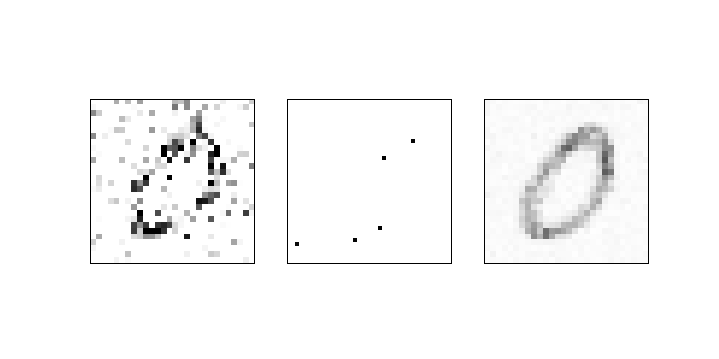

<IPython.core.display.Javascript object>


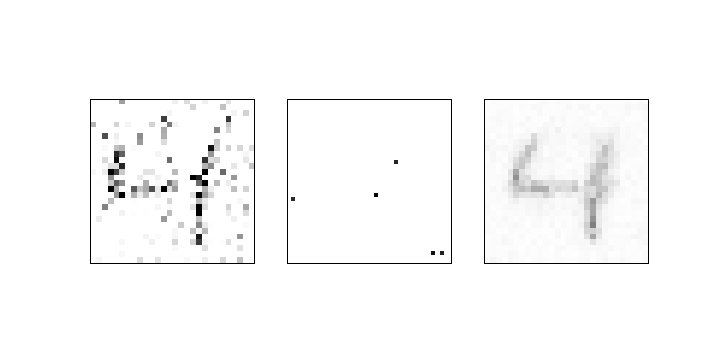

<IPython.core.display.Javascript object>


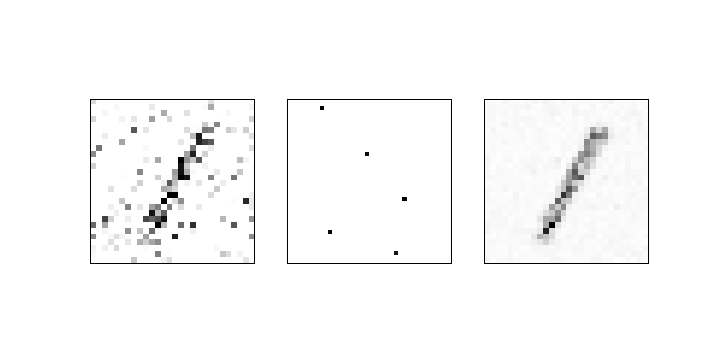

<IPython.core.display.Javascript object>


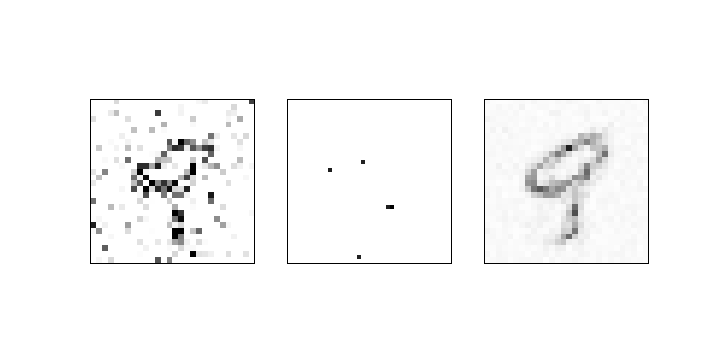

<IPython.core.display.Javascript object>


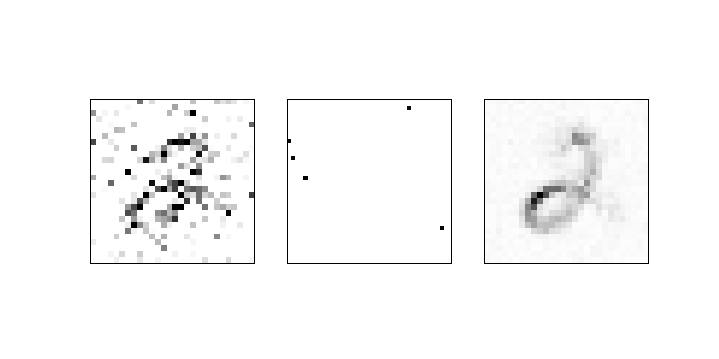

<IPython.core.display.Javascript object>


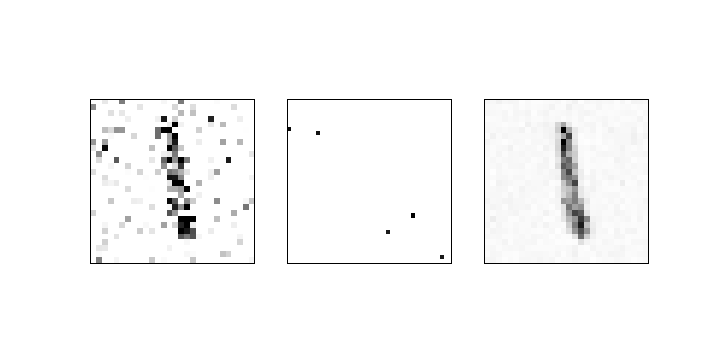

<IPython.core.display.Javascript object>


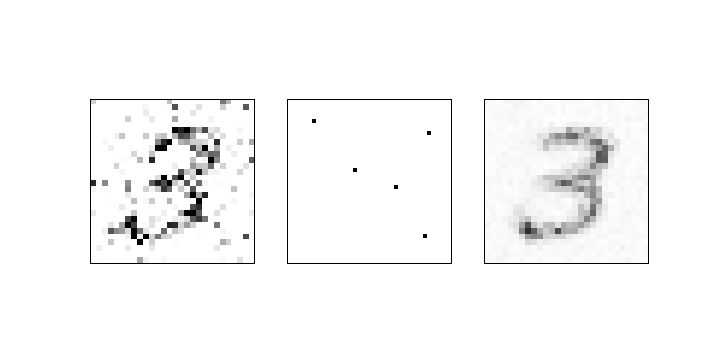

<IPython.core.display.Javascript object>


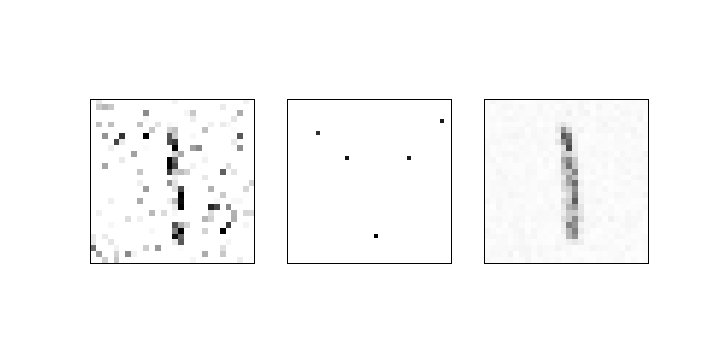

<IPython.core.display.Javascript object>


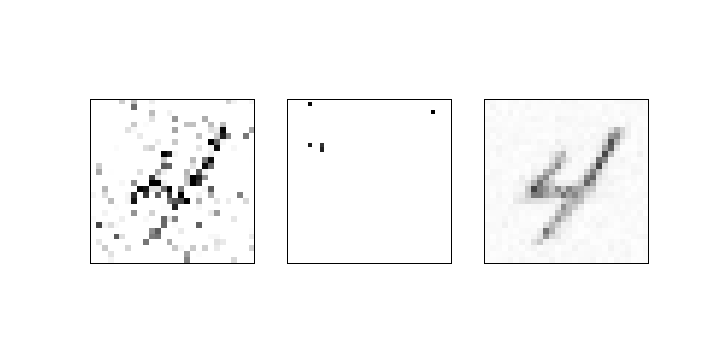

In [44]:
offset = 0

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky, gp_noise10, 1, 0, n_w)

The reconstructions are a bit rought, but I mean, given what the network had to work with, I feel like it did a pretty great job.

Ok, well, I think this just about wraps things up.

## Conclusions

Nothing super new. MWTA sparse coding is pretty darn good at finding structure in noisy inputs.  Man, the reconstruction just overhead of the 4 is incredibly dope.  This is just a cool indication that I seem to be moving in the corrent direction.

## Next steps

I need to build a network that enforces its internal hypotheses before it trains.  I think that network might be precisely what gets me from zero to hero.  Plus, I already did the work thinking about creating these noise signatures, so I can just poach them from my previous experiments.  Man, everything is dope.